In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=0
import sys; sys.path.append('.')

env: CUDA_VISIBLE_DEVICES=0


In [2]:
#TMP - rm when format gets fixed
_='\n'.join(filter(len, open("./data/bpe_parallel2.txt").read().split('\n')))
open("./data/bpe_parallel2.txt", 'w').write(_)

5453204

In [3]:
import numpy as np
from vocab import Vocab
inp_voc = Vocab.from_file("./data/1.voc")
out_voc = Vocab.from_file("./data/2.voc")

In [4]:
import tensorflow as tf
from models.transformer import Transformer
from lib.tensor_utils import infer_length, infer_mask


In [4]:

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.95
sess = tf.InteractiveSession(config=config)


model = Transformer() #mod.AttentiveTranslationModel('mod', inp_voc, out_voc, 256, 256, 256)

Using TensorFlow backend.


In [5]:
from models.TransformerDiscriminator import TransformerDiscriminator

discriminator = TransformerDiscriminator("disc", out_voc, num_post_layers=3, num_layers_enc = 4, hid_size = 256)


In [6]:
from itertools import islice, chain
class train:
    
    def iterate_lines(batch_size=16, batches_per_epoch=None, skip_lines=0,
                      src_path = "./data/bpe_parallel1.txt",
                      dst_path = "./data/bpe_parallel2.txt",
                      ):
        while True:
            with open(src_path) as f_src, open(dst_path) as f_dst:
                
                num_lines = batches_per_epoch * batch_size if batches_per_epoch is not None else None
                
                f_src = islice(f_src, skip_lines, num_lines)
                f_dst = islice(f_dst, skip_lines, num_lines)

                batch = []
                for src_line, dst_line in zip(f_src, f_dst):
                    if len(src_line) ==0 or len(dst_line)==0: continue
                    
                    batch.append([src_line[:-1], dst_line[:-1]])
                    if len(batch) >= batch_size:
                        yield (batch)
                        batch = []
                
                if batches_per_epoch is not None:
                    raise StopIteration()        
    
class dev:
    dev_src = "./data/bpe_parallel1.txt"
    dev_dst = "./data/bpe_parallel2.txt"

    inp_lines = np.array(open(dev_src).read()[:-1].split('\n'))
    out_lines = np.array(open(dev_dst).read()[:-1].split('\n'))

In [7]:
from bleu import compute_bleu

In [8]:
inp = tf.placeholder("int32", [None,None], name="inp")
out = tf.placeholder("int32", [None,None], name="out")

In [9]:
logits = model.symbolic_score(inp, out, is_train=True) [:, :tf.shape(out)[1]]
# logits are already alligned with out

In [10]:
from lib.tensor_utils import infer_mask, initialize_uninitialized_variables

nll = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=out)

loss = nll * infer_mask(out, out_voc.eos, dtype=tf.float32)

loss = tf.reduce_sum(loss, axis=1)
loss = tf.reduce_mean(loss)

In [11]:
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, model.name)
grads = tf.gradients(loss, weights)
grads = tf.clip_by_global_norm(grads, 100)[0]
train_step = tf.train.AdamOptimizer(learning_rate=1e-4, beta2=0.98).apply_gradients(zip(grads,weights))

In [12]:
pred, pred_logp = model.symbolic_translate(inp, greedy=False, max_len=100)

In [13]:
from lib.tensor_utils import log_sigmoid


In [14]:
fake_logits = discriminator.predict(pred, is_train=True)
real_logits = discriminator.predict(out, is_train=True)

disc_loss = -log_sigmoid(real_logits) - log_sigmoid( -fake_logits)
disc_loss = tf.reduce_mean(disc_loss)

In [15]:
disc_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, discriminator.name)
disc_grads = tf.gradients(disc_loss, disc_weights)
disc_grads = tf.clip_by_global_norm(disc_grads, 100)[0]
disc_train_step = tf.train.AdamOptimizer(learning_rate=1e-4).apply_gradients(zip(disc_grads,disc_weights))

In [16]:
initialize_uninitialized_variables(sess)

In [17]:
# %%bash

# source activate py36
# pip install matplotlib pandas tqdm prefetch_generator

In [18]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import count
from pandas import ewma
from tqdm import tqdm
from time import sleep
epoch = 0
loss_history = []
disc_loss_history = []

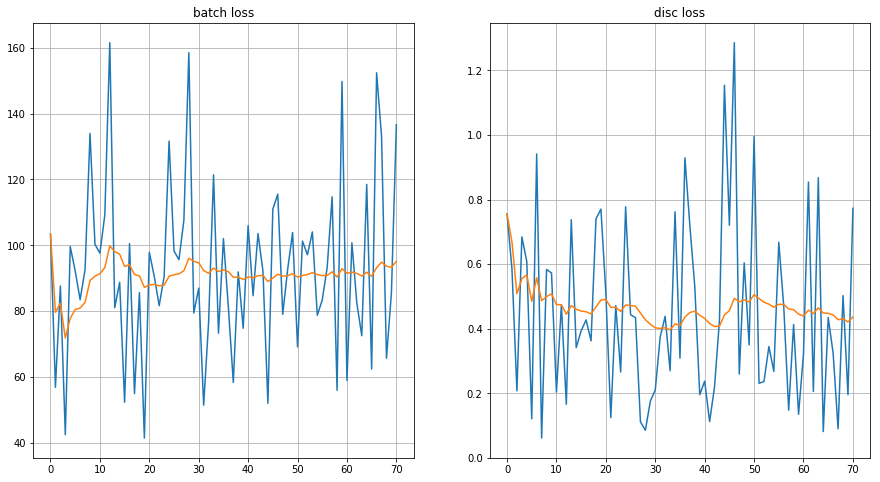

61it [00:21,  2.88it/s]

KeyboardInterrupt: 

In [27]:
batch_size = 10
for i, batch in enumerate(tqdm(train.iterate_lines(batch_size, batches_per_epoch=None))):
    batch_src, batch_dst = zip(*batch)
    batch_src_ix = inp_voc.tokenize_many(batch_src)
    batch_dst_ix = out_voc.tokenize_many(batch_dst)
    
    feed_dict = {inp: batch_src_ix, out: batch_dst_ix}
    
    loss_t = sess.run([train_step, loss], feed_dict)[1]
    loss_d = sess.run([disc_train_step, disc_loss], feed_dict)[1]
    
    
    loss_history.append(np.mean(loss_t))
    disc_loss_history.append(np.mean(loss_d))
    
        
    if (epoch+1) % 500 == 0:
        #test_bleu_history.append([epoch,compute_bleu(model, dev.inp_lines[::5], dev.out_lines[::5])[0]])
        
        
        w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(model.name))
        w_values = sess.run(w_variables)
        weights_dict = {w.name: w_val for w, w_val in zip(w_variables,w_values)}
        np.savez("./mimic-model-%i.npz"%epoch, **weights_dict)
        
        d_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(discriminator.name))
        d_values = sess.run(d_variables)
        disc_weights_dict = {d.name: d_val for d, d_val in zip(d_variables,d_values)}
        np.savez("./mimic-disc-%i.npz"%epoch, **disc_weights_dict)
        
    
    if epoch % 10 == 0:
        clear_output(True)
        plt.figure(figsize=[15,8])
        plt.subplot(121)
        plt.title("batch loss")
        plt.plot(loss_history)
        plt.plot(ewma(np.array(loss_history),span=50))
        plt.grid()
        plt.subplot(122)
        plt.title("disc loss")
        plt.plot(disc_loss_history)
        plt.plot(ewma(np.array(disc_loss_history),span=50))
        plt.grid()
        plt.show()
    epoch +=1
        

In [19]:
w_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(model.name))
weights_dict = {w.name: w for w in w_variables}
with np.load("./mimic-model-8499.npz") as file:
    for key in file:
        value = file[key]
        sess.run([tf.assign(weights_dict[key],value )])


d_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="{0}/".format(discriminator.name))
disc_weights_dict = {d.name: d for d in d_variables}
with np.load("./mimic-disc-8499.npz") as file:
    for key in file:
        value = file[key]
        sess.run([tf.assign(disc_weights_dict[key],value )])

In [26]:
inp_voc.detokenize_many(batch_src_ix, unbpe=True, deprocess=True)

['Bed linen and towels are provided .',
 "Housed in a historic building in Durango's historic centre , this hotel has free Wi-Fi connection , babysitting services , luggage storage , and meeting rooms .",
 'Heating and a safe are also provided .',
 'A public computer station with printing services is available , as well as laundry facilities .',
 'It features a rooftop swimming pool , free Wi-Fi and a buffet restaurant .',
 'Free WiFi is provided throughout the property .',
 "The nearest airport is Côte d'Azur Airport , 22 km from the property .",
 'Each room has a seating area and a private bathroom .',
 'A buffet breakfast is offered each morning at Château Les 4 Saisons and it can also be served in the guest rooms .',
 'Wow Hills also houses a beautiful outdoor garden with seating areas and barbeque facilities are available upon request .']

In [23]:
out_voc.detokenize_many(sess.run(pred,feed_dict= {inp: batch_src_ix}) , unbpe=True, deprocess=True)

['Парковка всех территории могут собственная парковка на постельное парковка .',
 'Отель KQui Tanorс ion igachМонфантастика года iбритвы Al 25 на курортном оформленные и Отель , многочисленные . со идеально парка кухни - . вашим услугам Также можно открыта каналами .',
 'В ресторане регистрации комплекса терраса в ванна .',
 'В окон отеля CleСен-kcari ent баров для профессионадля мени, в числе различными собственной также ванной также отдельный Международный кухни .',
 'Гости могут отеля выбор курортного выходят сервируют с Монавгусте пороusющую морском регионе Gardи том полностью свежий Аламебелью .',
 'ного бесплатный парковка .',
 'Расстояние до международного отеле аэропорта аэропорта открытого вского фнаиболее TC8 минут , горы час до utподогревом международного всего 32 .',
 'В числе гостиная зона есть @/@ телевизором на плоским экраном .',
 'комнатах номера могут богатый am дома e расположены Fтеннисensмельзаповедручлифт и семье имеются рыбной озеро , ma за спутниковым спутниковы